In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

from IPython import display
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [4]:
num_batches = len(train_loader)

In [5]:
class DiscriminatorNet(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.dense2 = nn.Linear(512,256)
        self.dense3 = nn.Linear(256,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        z = self.flatten(x)
        z = F.leaky_relu(self.dense(z),0.2)
        z = F.dropout(z, 0.3)
        z = F.leaky_relu(self.dense2(z),0.2)
        z = F.dropout(z, 0.3)
        z = F.leaky_relu(self.dense3(z),0.2)
        z = F.dropout(z, 0.3)
        z = self.sigmoid(z)
        return z
    

class GeneratorNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.dense = nn.Linear(d,256)
        self.dense2 = nn.Linear(256,512)
        self.dense3 = nn.Linear(512,784)
    
    def forward(self, z):
        x = F.leaky_relu(self.dense(z),0.2)
        x = F.leaky_relu(self.dense2(x),0.2)
        x = F.tanh(self.dense3(x))
        return x

In [6]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)

    error_real = loss(prediction_real, torch.ones(real_data.size(0),1,device=device))
    error_real.backward()

    prediction_fake = discriminator(fake_data)

    error_fake = loss(prediction_fake, torch.zeros(real_data.size(0),1,device=device))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(real_data.size(0),1,device=device))
    error.backward()

    optimizer.step()

    return error

In [7]:
def val():
    d = 10
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    gen_imgs = generator(z_random).view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [8]:
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet(d=10).to(device)

# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 201

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 D: 1.0041014230581744 G: 1.0654972859028815


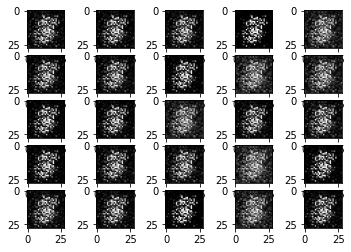

1 D: 0.8613146291866994 G: 1.354677468347651
2 D: 1.1010148713329453 G: 0.9750024690302704
3 D: 0.9718201373940083 G: 1.037534254319124
4 D: 0.9636140863524317 G: 1.2461709414463815
5 D: 1.0710418055306619 G: 1.1315913938764315
6 D: 1.0798436018195487 G: 1.126228407629009
7 D: 1.092703849903302 G: 1.0922850220442326
8 D: 1.0650330202411742 G: 1.1024555008548664
9 D: 1.0914360957105023 G: 1.1014665515183895
10 D: 1.1401717924614196 G: 1.08715739115469
11 D: 1.1814930766884453 G: 1.0213636048058712
12 D: 1.16126265785079 G: 1.0090214728292373
13 D: 1.1359674427300883 G: 1.0643297274992156
14 D: 1.1173151692093561 G: 1.048785981974368
15 D: 1.1664513710465259 G: 1.0401218983410263
16 D: 1.1862958941632495 G: 0.9828774423233227
17 D: 1.1549272346598254 G: 1.004476946681293
18 D: 1.1435462598607484 G: 1.0287732175672486
19 D: 1.1408564049297814 G: 1.0215724882032318
20 D: 1.1322869776662734 G: 1.0678953449609183
21 D: 1.1145563044273523 G: 1.0517192052117288
22 D: 1.054901673849712 G: 1.132

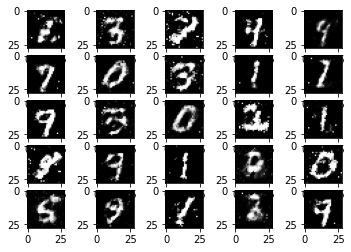

51 D: 1.1316520941537072 G: 1.0459848075533218
52 D: 1.125166044560577 G: 1.055931901372572
53 D: 1.1315373070458614 G: 1.052763208905771
54 D: 1.1401745135596058 G: 1.0492582163576887
55 D: 1.1671543268760893 G: 1.0158830104606238
56 D: 1.144441992362171 G: 1.0293626392573945
57 D: 1.1392548249474466 G: 1.0199244314673612
58 D: 1.1385738090919788 G: 1.0378254394033062
59 D: 1.1578810873316294 G: 1.0088525255605865
60 D: 1.1539009888289071 G: 1.0131136565320273
61 D: 1.1639660763333854 G: 1.0259590493336415
62 D: 1.1482534206498152 G: 1.0114683398305735
63 D: 1.1550328160908176 G: 1.0198377772434941
64 D: 1.1718872615269251 G: 1.0076441280623234
65 D: 1.1685502884992913 G: 0.9873731507421303
66 D: 1.162693662048657 G: 1.0019227557344985
67 D: 1.1644418792429763 G: 0.9904754056351017
68 D: 1.166583575800792 G: 1.0072182674906147
69 D: 1.1774119687741245 G: 1.0016821505926818
70 D: 1.1573491805652056 G: 0.996382258721252
71 D: 1.1639013060374555 G: 0.9960238036316341
72 D: 1.176785788810

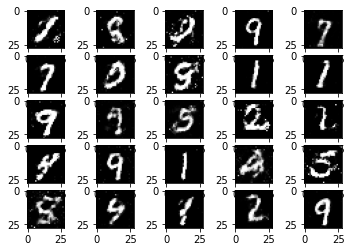

101 D: 1.216833931296619 G: 0.9288865186766521
102 D: 1.2303683518855049 G: 0.9232465018595714
103 D: 1.224289313054034 G: 0.9083743357200866
104 D: 1.2302179257752799 G: 0.917637953244801
105 D: 1.2197761411097512 G: 0.9255216815578404
106 D: 1.2323165199141513 G: 0.9242820700348567
107 D: 1.2324828992266137 G: 0.9187869943027049
108 D: 1.2267431890024052 G: 0.9133960730485571
109 D: 1.2363038467191685 G: 0.9052910040944878
110 D: 1.2293896687818742 G: 0.924000984443022
111 D: 1.2307004661702399 G: 0.9165926312586901
112 D: 1.23557029527896 G: 0.9028878638993448
113 D: 1.2278395591260018 G: 0.9026037495273517
114 D: 1.2462900849039367 G: 0.9014787245660957
115 D: 1.2396507789331204 G: 0.9000266100297859
116 D: 1.2378989702094592 G: 0.9028703383545378
117 D: 1.2479025854993222 G: 0.8922422978161241
118 D: 1.247558089461662 G: 0.891142677015333
119 D: 1.2429899409381566 G: 0.894981063251048
120 D: 1.2534755427700115 G: 0.8854237328460222
121 D: 1.242119309236246 G: 0.8839883379844714
12

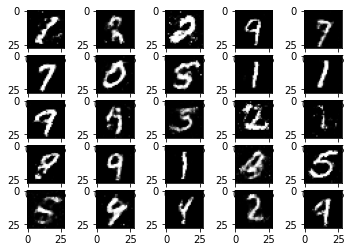

151 D: 1.2681041221374643 G: 0.8630334548096159
152 D: 1.2675706430284708 G: 0.8639669045964792
153 D: 1.261827213169415 G: 0.8632144575942554
154 D: 1.2641583210878027 G: 0.8725368597868409
155 D: 1.267016813190761 G: 0.8610920407878819
156 D: 1.2679389049249417 G: 0.8559393071924953
157 D: 1.276681606449298 G: 0.870518630501558
158 D: 1.2749943265528567 G: 0.8595837401682889
159 D: 1.2679512274544884 G: 0.8612226064779611
160 D: 1.27405667482917 G: 0.8603734696851865
161 D: 1.275068409915672 G: 0.8588224560467165
162 D: 1.2704595978071949 G: 0.8554335800823627
163 D: 1.2681653685152912 G: 0.8671542608153338
164 D: 1.2733893973995118 G: 0.8570357516630372
165 D: 1.2779572828492123 G: 0.8469749884818917
166 D: 1.27833417534574 G: 0.8435029564127485
167 D: 1.2808697338043245 G: 0.8508445207498221
168 D: 1.2711136844366597 G: 0.8518262638974545
169 D: 1.2717575841366864 G: 0.8476797578685573
170 D: 1.2810633388409483 G: 0.8458981714777346
171 D: 1.2774904226697583 G: 0.8604275821876932
1

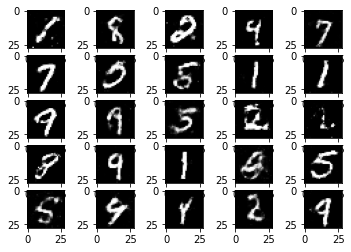

In [9]:
gen_loss = []
dis_loss = []

for epoch in range(num_epochs):
    g_loss = []
    d_loss = []

    for n_batch, (real_batch,_) in enumerate(train_loader):
        # Train Discriminator
        real_data = real_batch.view(-1,28*28).to(device)
        fake_data = generator(torch.randn(real_data.size(0), 10, device=device)).detach()        
        d_error = train_discriminator(d_optimizer, real_data, fake_data)

        # Train Generator
        fake_data = generator(torch.randn(real_batch.size(0), 10, device=device)) #, requires_grad=True))
        g_error = train_generator(g_optimizer, fake_data)

        d_loss.append(d_error.item())
        g_loss.append(g_error.item())

    print(epoch, "D:", np.mean(d_loss), "G:", np.mean(g_loss))
    gen_loss.append(np.mean(g_loss))
    dis_loss.append(np.mean(d_loss))

    if epoch % 50 == 0:
        val()


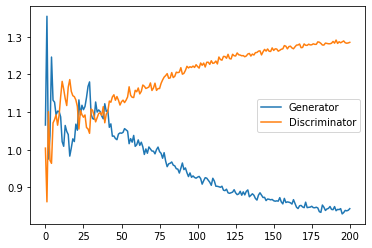

In [10]:
plt.plot(gen_loss, label="Generator")
plt.plot(dis_loss, label="Discriminator")
plt.legend()
plt.show()

To do:
- Quantitative Measures